In [1]:
import scanpy as sc
sc.set_figure_params()
from cellrank.tl.kernels import CytoTRACEKernel
import scvelo as scv
def get_cytotrace(adata):
    sc.pp.filter_genes(adata, min_cells=10)
    scv.pp.normalize_per_cell(adata)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata)

    adata.layers["spliced"] = adata.X
    adata.layers["unspliced"] = adata.X
    scv.pp.moments(adata, n_pcs=30, n_neighbors=30)
    ctk = CytoTRACEKernel(adata)

In [2]:
adata=sc.read("counts_unfiltered/adata.h5ad")

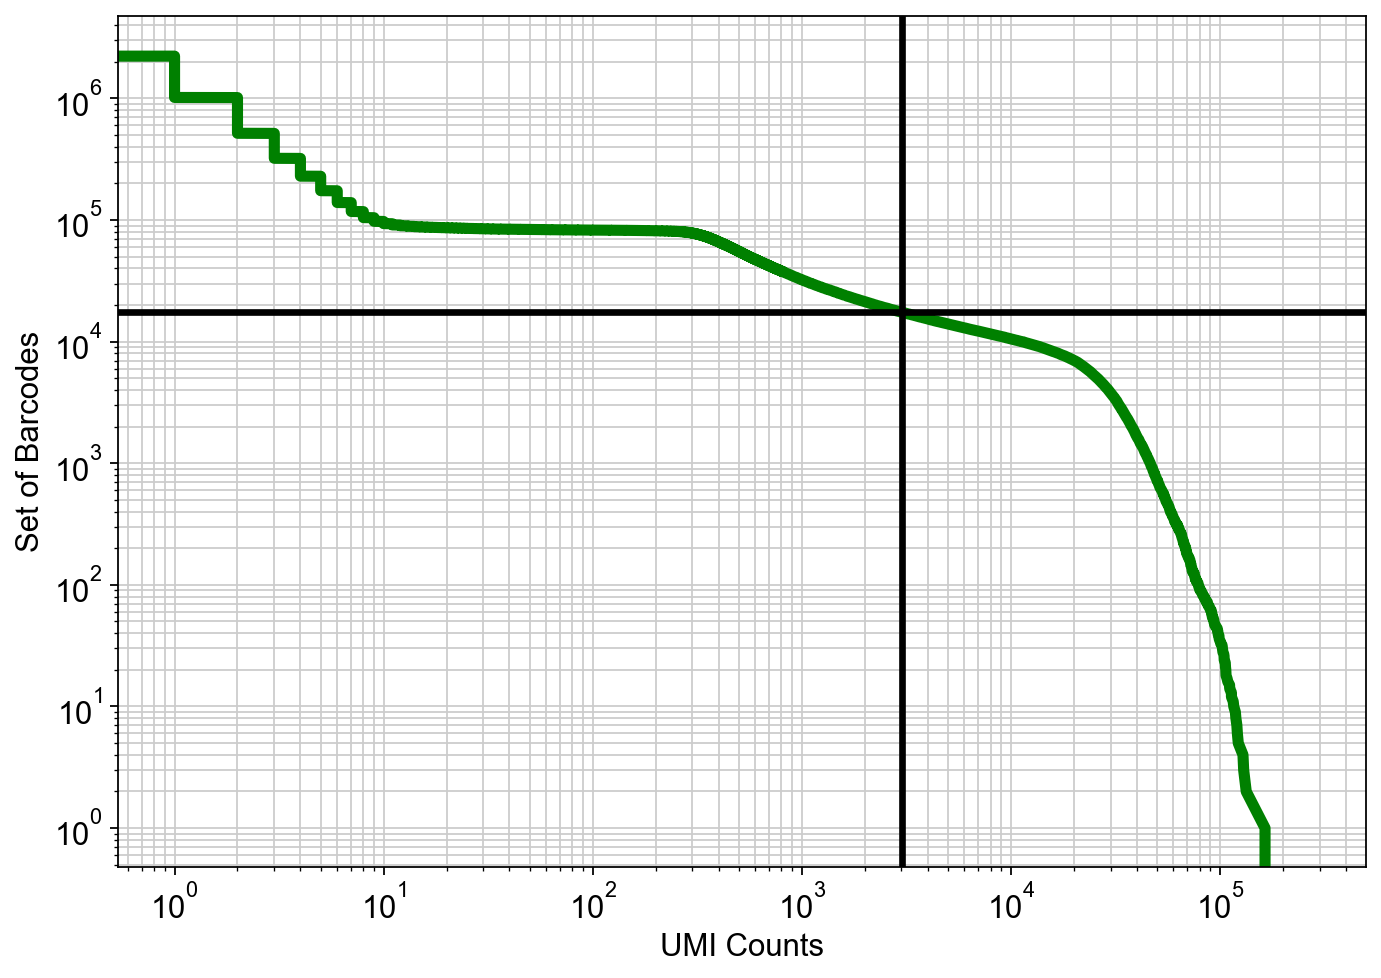

In [3]:
import numpy as np
import matplotlib.pyplot as plt
#@title Threshold cells according to knee plot { run: "auto", vertical-output: true }
expected_num_cells =  17415#@param {type:"integer"}
knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]

fig, ax = plt.subplots(figsize=(10, 7))

ax.loglog(knee, range(len(knee)), linewidth=5, color="g")
ax.axvline(x=knee[expected_num_cells], linewidth=3, color="k")
ax.axhline(y=expected_num_cells, linewidth=3, color="k")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
plt.show()


In [4]:
sc.pp.filter_cells(adata, min_counts=1e4)

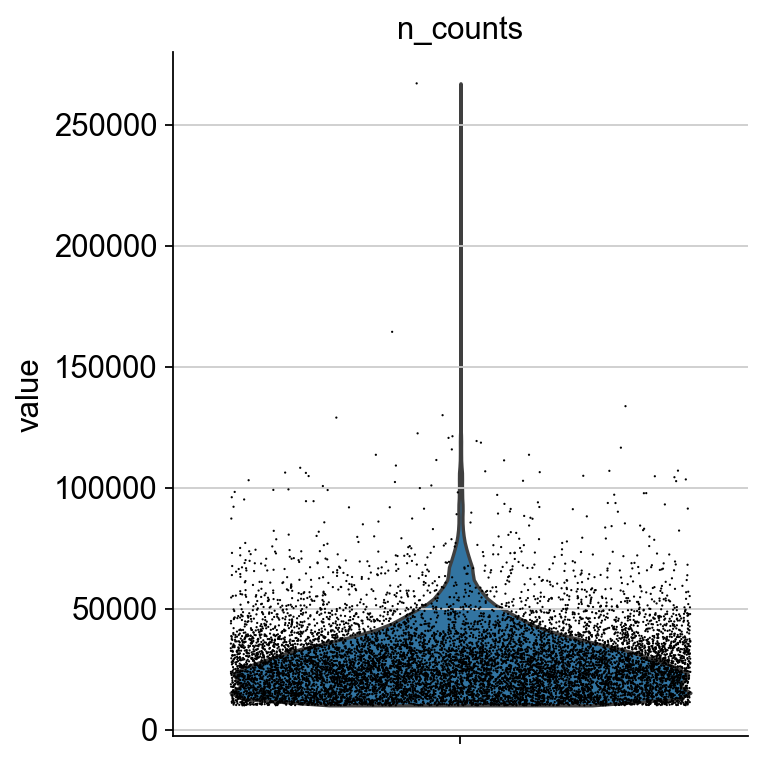

In [5]:
sc.pl.violin(adata, ['n_counts'], jitter=0.4, multi_panel=True)

In [6]:
sc.pp.filter_cells(adata, max_counts=1e5)

In [7]:
adata

AnnData object with n_obs × n_vars = 10508 × 37859
    obs: 'n_counts'

In [8]:
import scFates as scf

Filtering cells
    obtaining gene and molecule counts
    fitting RLM
    finished (0:00:02) --> subsetted adata.


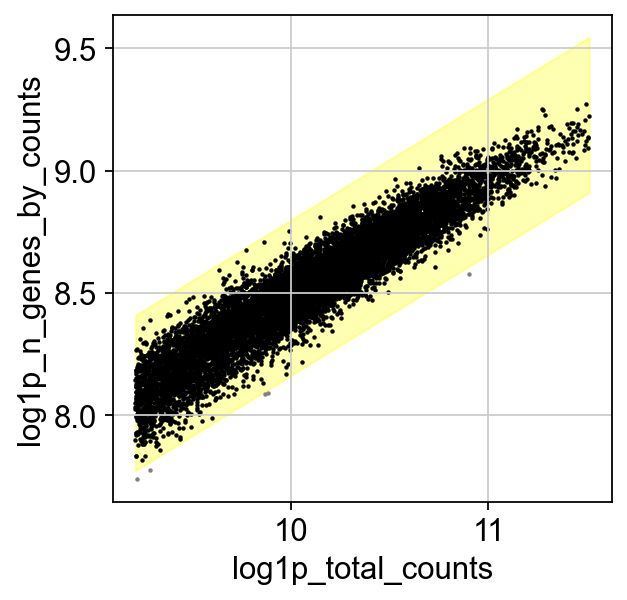

In [9]:
scf.pp.filter_cells(adata,plot=True)

In [10]:
adata_raw=adata.copy()

In [11]:
get_cytotrace(adata_raw)

Normalized count data: X.
computing neighbors
    finished (0:00:22) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:22) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [12]:
adata.obs["CytoTRACE"]=adata_raw.obs.ct_score

In [13]:
adata.raw=adata

In [14]:
sc.pp.normalize_total(adata,target_sum=1e3)
sc.pp.log1p(adata)

Finding overdispersed features
    computing mean and variances
    gam fitting
    found 5501 over-dispersed features (0:00:02) --> added 
    .var['res'], residuals of GAM fit.
    .var['lp'], p-value.
    .var['lpa'], BH adjusted p-value.
    .var['qv'], percentile of qui-squared distribution.
    .var['highly_variable'], feature is over-dispersed.



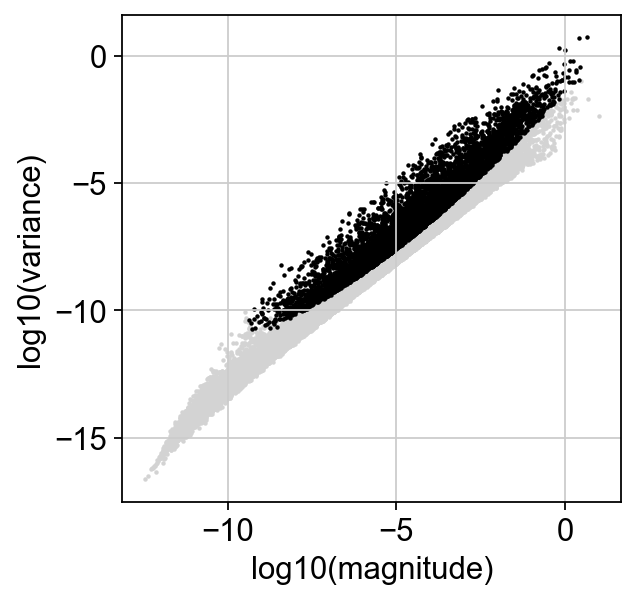

In [15]:
sc.pp.filter_genes(adata,min_cells=3)
scf.pp.find_overdispersed(adata,plot=True)

In [16]:
adata=adata[:,adata.var["highly_variable"]]

In [17]:
sc.pp.scale(adata)
sc.pp.pca(adata)

/home/lfaure/tools/scanpy/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [18]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30)

sc.tl.umap(adata,method="rapids")

In [23]:
sc.tl.leiden(adata,resolution=1,flavor="rapids")

In [20]:
adata

AnnData object with n_obs × n_vars = 10503 × 5501
    obs: 'n_counts', 'CytoTRACE', 'leiden'
    var: 'n_cells', 'm', 'v', 'n_obs', 'res', 'lp', 'lpa', 'qv', 'highly_variable', 'mean', 'std'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

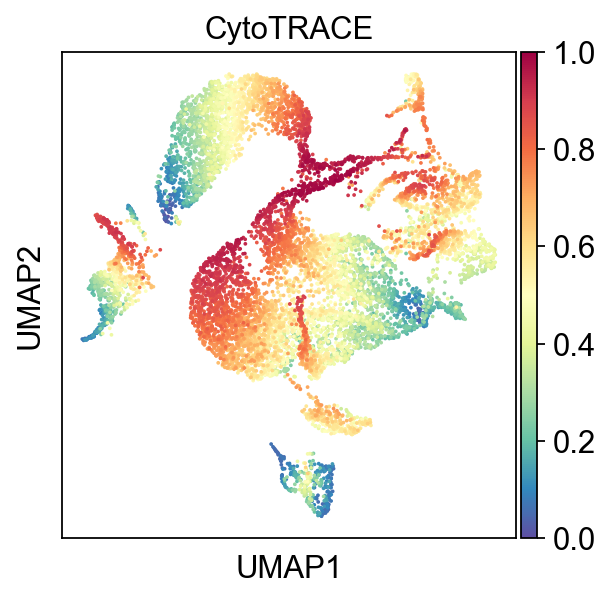

In [21]:
sc.pl.umap(adata,color='CytoTRACE',cmap="Spectral_r")

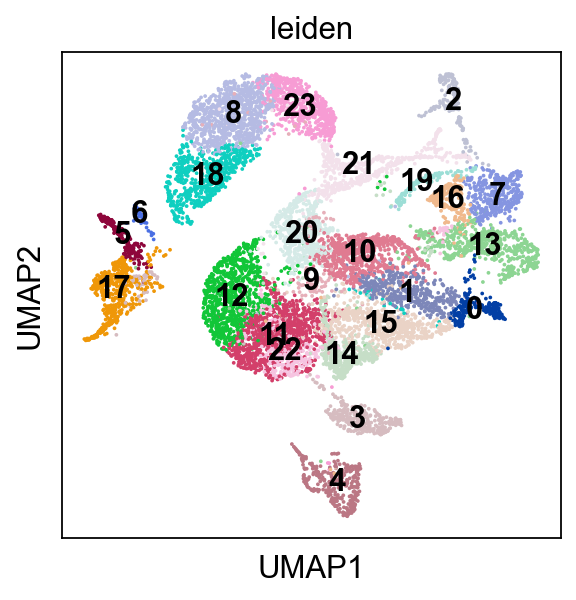

In [24]:
sc.pl.umap(adata,color='leiden',legend_loc='on data')

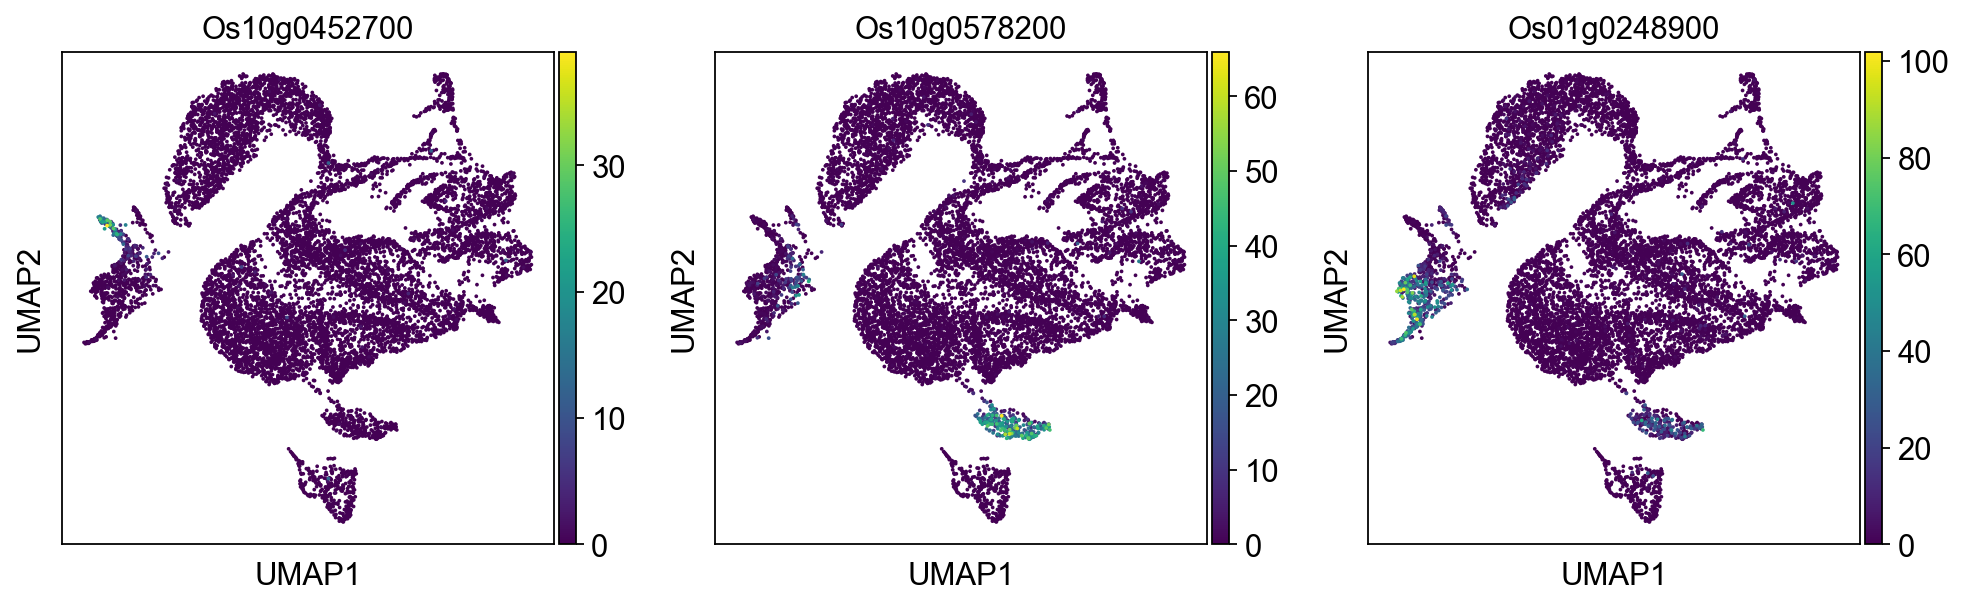

In [25]:
sc.pl.umap(adata,color=["Os10g0452700","Os10g0578200","Os01g0248900"])

In [26]:
adata=adata[adata.obs.leiden.isin(["3","5","17"])]

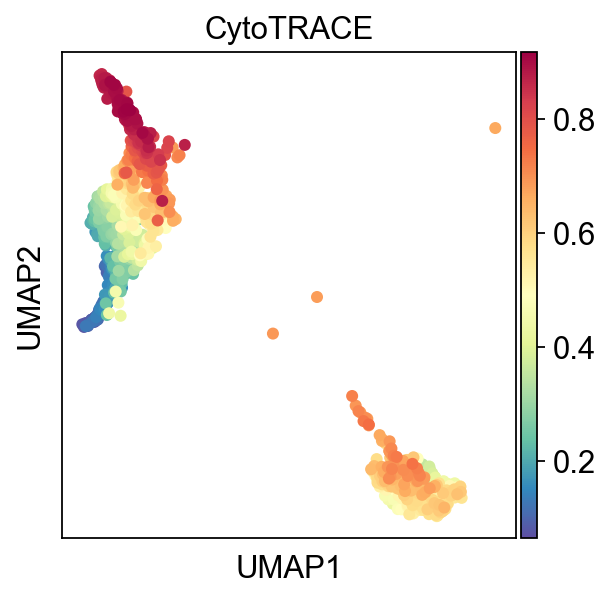

In [27]:
sc.pl.umap(adata,color='CytoTRACE',cmap="Spectral_r")

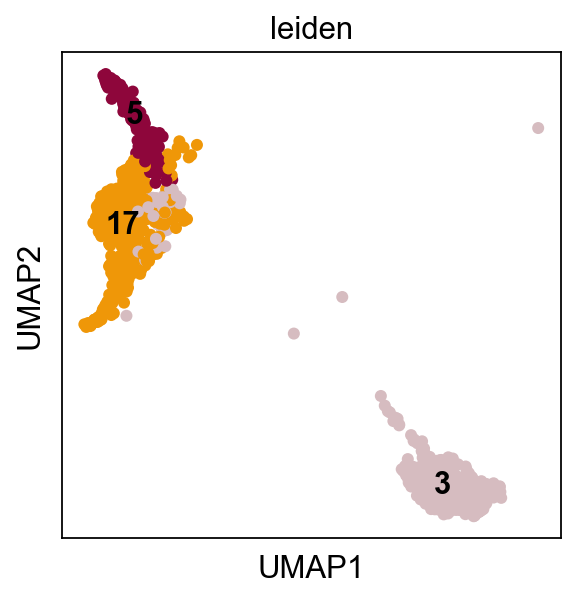

In [28]:
sc.pl.umap(adata,color='leiden',legend_loc='on data')

In [29]:
scf.pp.diffusion(adata)

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.


Running Diffusion maps 
Determing nearest neighbor graph...
    determining multiscale diffusion space
    finished (0:00:01) --> added 
    .obsm['X_diffusion_multiscale'], multiscale diffusion space.


In [30]:
sc.pp.neighbors(adata,n_neighbors=30,use_rep='X_diffusion_multiscale')

In [31]:
sc.tl.draw_graph(adata,init_pos='X_umap',method="rapids")

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


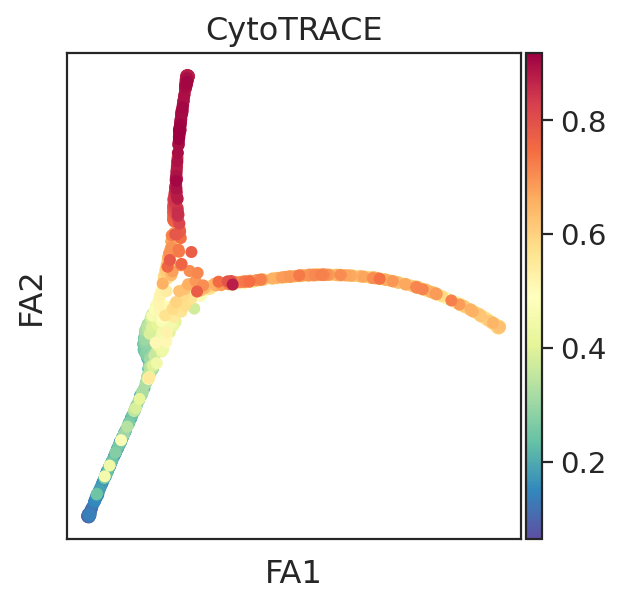

In [32]:
sc.pl.draw_graph(adata,color='CytoTRACE',cmap="Spectral_r")

In [33]:
adata.obsm["X_diffusion_multiscale"]

array([[ 1.04800174, -1.28803711,  0.75014012],
       [-2.05726436,  0.32682668,  0.11244002],
       [ 1.0555466 , -0.8604981 ,  0.8959894 ],
       ...,
       [ 1.5333954 ,  0.63838661,  0.68738555],
       [ 1.17748247, -2.38493779, -1.35072282],
       [ 1.07925312, -0.63768934,  0.88206919]])

In [34]:
adata.write("adata_preprocess.h5ad")